In [1]:
from __future__ import division
from modules import * 
%matplotlib inline 

### Gridworld Environment

0.1


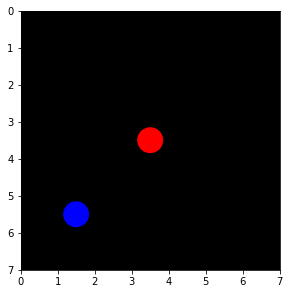

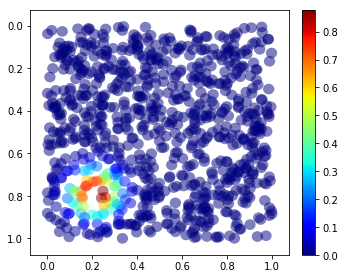

In [2]:
y_new = 7
x_new = 7
eu.height = y_new
eu.width = x_new
fwhm_range = np.linspace(0.05,0.5,6)

fwhm = 0.1

fig_savedir = '../data/outputs/gridworld/figures/'
#make environment
maze = eu.gridworld([eu.height, eu.width],
                    rho        = eu.obs_rho,
                    num_pc     = eu.place_cells, 
                    pc_fwhm    = fwhm, 
                    maze_type  = 'none', 
                    port_shift = eu.portshift)
maze.rwd_loc = [(int(y_new/2),int(x_new/2))]
print maze.fwhm
for i in maze.rwd_loc: 
    maze.orig_rwd_loc.append(i)

#show environment
eu.make_env_plots(maze,1,1)

## test out gridworld wrapper. 
env = eu.gymworld(maze)

### Model Free Controller

In [3]:
# MF module parameters
input_dim  = env.observation_space.shape[0]
action_dim = env.action_space.n
h_dims     = [400]
h_types    = ['linear'] #lstm does not work yet, presumably also gru
MF = mf.AC_Net(input_dim, action_dim, hidden_dimensions = h_dims, hidden_types = h_types)
discount_factor = 0.98

#learning parameters
eta = 5e-4 #gradient descent learning rate
opt = mf.optim.Adam(MF.parameters(), lr = eta)

### Episodic Controller

In [4]:
# EC module parameters
use_EC = True
EC = ec.ep_mem(MF,int(0.75*np.prod(maze.grid.shape)*env.action_space.n)) # memory limit should be ~75% of #actions x #states

# SIMULATION RUN

In [6]:
#----------------
# Run Parameters
#----------------
NUM_TRIALS = 1000
NUM_EVENTS = 300

# --------------------------------
# empty data frames for recording
# --------------------------------
EC.reset_cache()
EC.reward_unseen = True 
add_mem_dict = {} #dictionary of items which get put into memory cache
timestamp = 0
success_benchmark = 0.95 # average success before employing EC or removing most rewarded port

# data frames for value and policy maps
total_loss    = [[],[]]           # keep track of policy loss and value loss 
total_reward  = []                # keep track of rewards achieved per trial
val_maps      = []                # keep a list of state value arrays for each trial
value_map     = maze.empty_map    # array of state values

# flags to be changed mid run
rwd_threshold = True

# --------------------------------
# optional settings for recording
# --------------------------------
add_episodic_cache = False  ## Possibly unnecessary now 
midrun_rwd_removal = False
track_occupancy    = False
track_MF_policies  = False
track_CS           = False
track_KLD          = True

if midrun_rwd_removal: 
    reward_tally = {}
    for _ in maze.rwd_loc: 
        reward_tally[_] = []
    trial_rwd_switch = 0

if track_occupancy: 
    occ_list = []
if track_MF_policies:
    track_policy_dict = {}
if track_CS:
    track_confidence_score = [[],[]] #[[rewards],[computed confidence score]]
if track_KLD:
    policy_KLD = [[],[]]
    ec_kld = eu.KLD_holder(maze)
    mf_kld = eu.KLD_holder(maze)
    
deltas = []
    
# record current time before beginning of trial
print_freq = 1/10
runtime = time.time()
blocktime = time.time()
print "Run started: "
#==================================
# Run Trial
#==================================
for trial in xrange(NUM_TRIALS):
    trialstart_stamp = timestamp
    state       = Variable(torch.FloatTensor(env.reset()))
    reward_sum  = 0
    v_last      = 0
    reward_last = 0 
    if track_occupancy:
        occupancy = np.zeros((eu.height, eu.width))
    if track_KLD:
        ec_kld.reset()
        mf_kld.reset()
        if trial == NUM_TRIALS-1:
            MF_pol_map = eu.KLD_holder(maze, track='policy')
            EC_pol_map = eu.KLD_holder(maze, track='policy')
    
    track_deltas = []
    trial_start = time.time()
    
    for event in xrange(NUM_EVENTS):
        if track_occupancy:
            occupancy[maze.cur_state[1], maze.cur_state[0]] += 1
            
        # pass state through MF module
        policy_, value_ = MF(state)
        
        # pass state through EC module
        if use_EC:
            add_mem_dict['state'] = maze.cur_state
            #policy_EC = EC.recall_mem(tuple(state.data[0]))
            #policy_ = EC.composite_policy(policy_, policy_EC,reward)    # get policy composed of MF and EC outputs
        
        choice, policy, value = mf.select_action_end(MF,policy_, value_)
        
        if track_MF_policies:
            track_policy_dict[maze.cur_state] = policy, timestamp
        
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)
        
        MF.rewards.append(reward)
        delta = reward + discount_factor*value - v_last  #compute eligibility trace/rpe approximation
        
        if use_EC:
            add_mem_dict['activity']  = tuple(state.data[0])
            add_mem_dict['action']    = choice
            add_mem_dict['delta']     = delta
            add_mem_dict['timestamp'] = timestamp            
            EC.add_mem(add_mem_dict,mixing=False, keep_hist=True)             #add event to memory cache
            if reward != 0:
                EC.reward_update(trialstart_stamp, timestamp, reward)
            track_deltas.append(delta[0])
                
        if track_KLD:
            mf_kld.update(maze.cur_state, policy)
            ec_kld.update(maze.cur_state, eu.softmax(EC.cache_list[tuple(state.data[0])][0],T=3))
            if trial == NUM_TRIALS-1:
                MF_pol_map.update(maze.cur_state, policy)
                EC_pol_map.update(maze.cur_state, eu.softmax(EC.cache_list[tuple(state.data[0])][0]))
            
            
        if track_CS:
            track_confidence_score[0].append(reward)
            track_confidence_score[1].append(EC.confidence_score)
            EC.compute_confidence(reward)

        state = Variable(torch.FloatTensor(next_state))       # update state
        reward_sum += reward
        reward_last = reward

        v_last = value
        
        timestamp += 1
    
    if add_episodic_cache:
        if use_EC==False and (len(total_reward)>50)  and (np.array(total_reward[-50:]).mean() > success_benchmark*NUM_EVENTS):
            if rwd_threshold:
                print " \t Started Memory at Trial ", trial
                if midrun_rwd_removal:
                    maxsums = {}
                    for item in reward_tally.items():
                        maxsums[item[0]] = sum(item[1])
                    most_rewarded_location = max(maxsums.iteritems(), key=operator.itemgetter(1))[0] 
                    maze.rwd_loc.remove(most_rewarded_location)
                    trial_rwd_switch = trial
                    print "removed reward at ", most_rewarded_location

                rwd_threshold = False
                use_EC = True

    if midrun_rwd_removal:
        if (trial_rwd_switch!=0) and (trial == trial_rwd_switch + 1000):
            maze.rwd_loc.append(most_rewarded_location)
   
    #--- AT end of trial, update weights     
    p_loss, v_loss = mf.finish_trial(MF, discount_factor,opt)
    
    total_loss[0].append(p_loss.data[0])
    total_loss[1].append(v_loss.data[0])
    total_reward.append(reward_sum)

    value_map = mf.generate_values(maze,MF,None)
    val_maps.append(value_map.copy())    
    
    if track_KLD:
        policy_KLD[0].append(mf_kld.map.copy())
        policy_KLD[1].append(ec_kld.map.copy())
        
    
    if midrun_rwd_removal:
        for item in maze.reward_tally.items():
            reward_tally[item[0]].append(item[1])
    if track_occupancy:
        occ_list.append(occupancy.copy())
    
    deltas.append(track_deltas)
    # print reward measure
    if trial%(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1: 
        print "[{0}]  Trial {1} total reward = {2} (Avg {3:.3f})".format(time.strftime("%H:%M:%S", time.localtime()), trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)
        blocktime = time.time() 
    
print "Run took {0:.3f}".format(time.time()-runtime)

Run started: 
[14:58:59]  Trial 0 total reward = 3 (Avg 0.010) Block took 1.908
[15:01:58]  Trial 100 total reward = 264 (Avg 0.880) Block took 179.432


KeyboardInterrupt: 

In [7]:
print len(EC.cache_list)
print trial

49
189


# Plots

### Loss & Reward

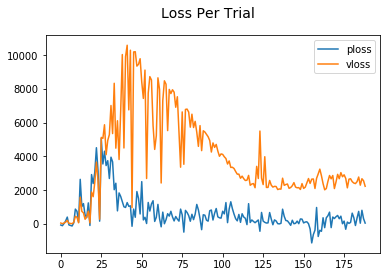

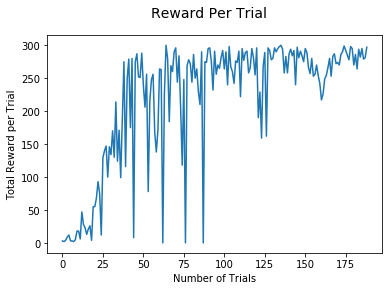

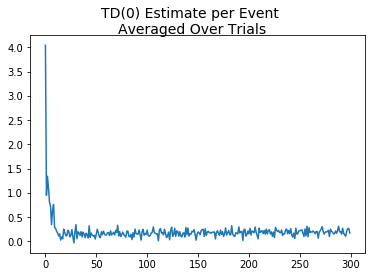

In [8]:
plt.figure(0)
plt.plot(total_loss[0], label='ploss')
plt.plot(total_loss[1], label='vloss')
plt.legend(loc=0)
plt.savefig(fig_savedir+'loss.svg',format='svg')
plt.suptitle('Loss Per Trial', fontsize=14)

plt.figure(1)
plt.plot(total_reward, label='rwd')
plt.xlabel("Number of Trials")
plt.ylabel("Total Reward per Trial")
plt.suptitle('Reward Per Trial', fontsize=14)
if midrun_rwd_removal:
    plt.axvline(x=trial_rwd_switch, color='r')
    #plt.axvline(x=trial_rwd_switch+1000, color='r')
plt.savefig(fig_savedir+'trialrwd.svg',format='svg')


avg_delta = []
for j in xrange(NUM_EVENTS):
    avg_sum = 0
    for i in xrange(len(deltas)):
        avg_sum += deltas[i][j]
    avg = avg_sum/NUM_EVENTS
    avg_delta.append(avg)
plt.figure(2)
plt.plot(avg_delta)
#plt.ylim([0,2])
plt.suptitle('TD(0) Estimate per Event \nAveraged Over Trials', fontsize=14)

plt.show()
plt.close()

### Value Maps 

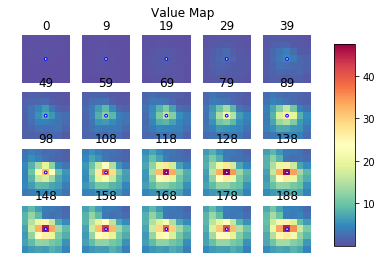

In [9]:
eu.print_value_maps(maze,val_maps,title='Value Map',save_dir=fig_savedir) ### see individual map with kwarg maps=X

### MFC-Generated Policy Map

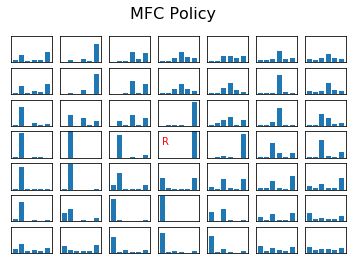

In [10]:
track_policy_dict = {}
for __ in maze.useable:
    temp_state = Variable(torch.FloatTensor(maze.mk_state(state=__)))
    policy_, value_ = MF(temp_state)
    track_policy_dict[__] = np.array(policy_.data[0])
    
plt.figure()
fig, ax = plt.subplots(maze.grid.shape[0],  maze.grid.shape[1])
for i in track_policy_dict:
    y_dim = i[0]
    x_dim = i[1]
    ax[i[1], i[0]].bar(np.arange(6), np.array(track_policy_dict[i])) #what was generated by network
    ax[i[1], i[0]].set_xticks([])
    ax[i[1], i[0]].set_yticks([])
    ax[i[1], i[0]].set_ylim([0,1])
    if i == maze.rwd_loc[0]:
        ax[i[1], i[0]].annotate('R', xy=(0,0.5), color='r')
#plt.savefig('policies.svg', format='svg')
fig.suptitle('MFC Policy', fontsize=16) 
plt.show()
plt.close()

### EC-Generated Policy Map

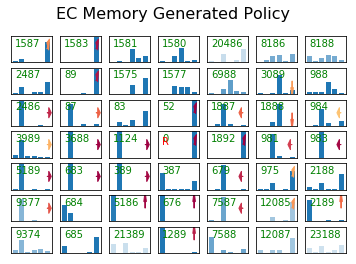

In [11]:
# policy maps in memory
if use_EC:
    test_frame = [(v[2],v[0], v[1],eu.softmax(v[0],T=1), maze.actionlist[np.argmax(eu.softmax(v[0]))], [x for _,x in sorted(zip(eu.softmax(v[0]),maze.actionlist), reverse=True)]) for (k,v) in EC.cache_list.items()]

    with open('mycsvfile.csv','wb') as f:
        w = csv.writer(f)
        w.writerows(test_frame)

    resultant_frame = {}
    for enum, i in enumerate(test_frame):
        resultant_frame[i[0]] = test_frame[enum][1:]


    plt.figure()
    fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
    cmap = plt.cm.Spectral_r
    cNorm  = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cm.ScalarMappable(norm = cNorm, cmap=cmap)

    for i in test_frame:
        state_loc = i[0]
        av = i[1]
        softmax = i[3]
        time_recorded = i[2]

        ax[state_loc[1], state_loc[0]].cla()
        alpha_factor = timestamp-time_recorded
        if alpha_factor == 0:
            alpha_factor = 0.1
        opacity = 5000./alpha_factor
        if opacity >1:
            opacity = 1
        ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax, alpha = opacity)
        arg_ = np.argmax(softmax)
        if softmax[arg_] > 0.65:
            dx1,dy1,_,__ = eu.make_arrows(arg_, softmax[arg_])
            colorVal1 = scalarMap.to_rgba(softmax[arg_])
            ax[state_loc[1], state_loc[0]].arrow(5,.5,dx1,dy1,head_width =0.4, head_length =0.4, color=colorVal1)
        ax[state_loc[1], state_loc[0]].set_xticks([])
        ax[state_loc[1], state_loc[0]].set_yticks([])
        ax[state_loc[1], state_loc[0]].set_ylim([0,1])
        ax[state_loc[1], state_loc[0]].annotate('{}'.format(timestamp -time_recorded), xy=(0,.6), color='g')
        if state_loc == maze.rwd_loc[0]:
            ax[state_loc[1], state_loc[0]].annotate('R', xy=(0,0.5), color='r')

    #plt.savefig('wlastaction10.svg', format='svg')
    fig.suptitle('EC Memory Generated Policy', fontsize=16) 
    plt.show()
    plt.close()

### Optimal Policy Map

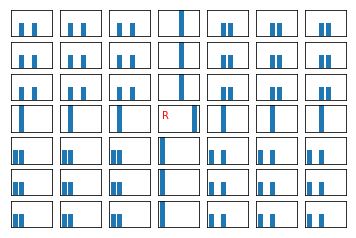

In [12]:
optimal_policy = eu.opt_pol_map(maze)
plt.figure()
fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cm.ScalarMappable(norm = cNorm, cmap=cmap)

for state_loc in maze.useable:
    ax[state_loc[1], state_loc[0]].cla()
    softmax  = optimal_policy[state_loc[1],state_loc[0]]
    ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax)
    ax[state_loc[1], state_loc[0]].set_xticks([])
    ax[state_loc[1], state_loc[0]].set_yticks([])
    ax[state_loc[1], state_loc[0]].set_ylim([0,1])
    
    if state_loc == maze.rwd_loc[0]:
        ax[state_loc[1], state_loc[0]].annotate('R', xy=(0,0.5), color='r')


plt.show()
plt.close()

### KL Divergence Plots

In [ ]:
KLD_means1 = [[],[],[],[]] # min, max, mean, median for MF
KLD_means2 = [[],[],[],[]] # EC



for i in xrange(len(policy_KLD[1])):
    #min
    KLD_means1[0].append(policy_KLD[0][i].min())
    KLD_means2[0].append(policy_KLD[1][i].min())
    #max
    KLD_means1[1].append(policy_KLD[0][i].max())
    KLD_means2[1].append(policy_KLD[1][i].max())
    #mean    
    KLD_means1[2].append(policy_KLD[0][i].mean())
    KLD_means2[2].append(policy_KLD[1][i].mean())
    #median
    KLD_means1[3].append(np.median(policy_KLD[0][i]))
    KLD_means2[3].append(np.median(policy_KLD[1][i]))
    
plt.figure()
# MF
run_mean_smoothing = 1
#plt.fill_between(np.arange(len(KLD_means1[0])), KLD_means1[0], KLD_means1[1], facecolor='b', alpha =0.3)
plt.plot(eu.running_mean(KLD_means1[2], run_mean_smoothing), 'b',label="MF Mean",alpha=1)
plt.plot(eu.running_mean(KLD_means1[3], run_mean_smoothing), 'b--',label="MF Median",alpha=1)
# EC
#plt.fill_between(np.arange(len(KLD_means1[0])), KLD_means2[0], KLD_means2[1], facecolor='g', alpha =0.3)
plt.plot(eu.running_mean(KLD_means2[2], run_mean_smoothing), 'g', label='EC Mean',alpha=1)
plt.plot(eu.running_mean(KLD_means2[3], run_mean_smoothing), 'g--', label='EC Median',alpha=1)

plt.legend(loc=0)
#plt.xlim([0,300])
#plt.ylim([0,50])
plt.savefig(fig_savedir+'KLD_avgs.svg',format='svg')
plt.show()
plt.close()

In [ ]:
track_fwhm_KLD = {}
track_fwhm_KLD[str(fwhm)] = KLD_means1, KLD_means2
plt.figure()
run_mean_smoothing = 10
#colours1 = 
track_fwhm_KLD.keys()[0] = str(0.05)
for i in xrange(len(track_fwhm_KLD)):
    ct=i*2
    KLD_means1 = track_fwhm_KLD[track_fwhm_KLD.keys()[i]][0]
    KLD_means2 = track_fwhm_KLD[track_fwhm_KLD.keys()[i]][1]
    # MF
    #Median
    plt.plot(eu.running_mean(KLD_means1[3], run_mean_smoothing), color=cm.tab20.colors[ct+1], label='MF '+str(track_fwhm_KLD.keys()[i]),alpha=1)
    #Mean
    #plt.plot(eu.running_mean(KLD_means1[2], run_mean_smoothing), color=cm.tab20.colors[ct+1], linestyle ='--',alpha=1)
    # EC 
    #Median
    plt.plot(eu.running_mean(KLD_means2[3], run_mean_smoothing), color=cm.tab20.colors[ct], label='EC '+str(track_fwhm_KLD.keys()[i]),alpha=1)
    #Mean
    #plt.plot(eu.running_mean(KLD_means2[2], run_mean_smoothing), color=cm.tab20.colors[ct],linestyle='--', alpha=1)

plt.suptitle('Median KLD For Different Place Cell FWHM Values')
plt.legend(loc=0)
plt.xlim([0,300])
#plt.ylim([0,50])
plt.show()
plt.close()

In [ ]:
### Make KLD Maps over time 
reload(eu)
eu.print_value_maps(maze,policy_KLD[0],title='MF KLD',save_dir=fig_savedir)
eu.print_value_maps(maze,policy_KLD[1],title='EC KLD',save_dir=fig_savedir, val_range=(0,10))

In [ ]:
plt.figure(0)
infopolicy = optimal_policy
fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cm.ScalarMappable(norm = cNorm, cmap=cmap)

for state_loc in maze.useable:
    ax[state_loc[1], state_loc[0]].cla()
    softmax  = infopolicy[state_loc[1],state_loc[0]]
    ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax)
    ax[state_loc[1], state_loc[0]].set_xticks([])
    ax[state_loc[1], state_loc[0]].set_yticks([])
    ax[state_loc[1], state_loc[0]].set_ylim([0,1])
    
    if state_loc == maze.rwd_loc[0]:
        ax[state_loc[1], state_loc[0]].annotate('R', xy=(0,0.5), color='r')
plt.suptitle('Optimal Policy', fontsize=14)
plt.show()
plt.close()

plt.figure(1)
infopolicy = MF_pol_map.map
fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cm.ScalarMappable(norm = cNorm, cmap=cmap)

for state_loc in maze.useable:
    ax[state_loc[1], state_loc[0]].cla()
    softmax  = infopolicy[state_loc[1],state_loc[0]]
    ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax)
    ax[state_loc[1], state_loc[0]].set_xticks([])
    ax[state_loc[1], state_loc[0]].set_yticks([])
    ax[state_loc[1], state_loc[0]].set_ylim([0,1])
    
    if state_loc == maze.rwd_loc[0]:
        ax[state_loc[1], state_loc[0]].annotate('R', xy=(0,0.5), color='r')
plt.suptitle('MF Policy', fontsize=14)
plt.show()
plt.close()


plt.figure(2)
infopolicy = EC_pol_map.map
fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cm.ScalarMappable(norm = cNorm, cmap=cmap)

for state_loc in maze.useable:
    ax[state_loc[1], state_loc[0]].cla()
    softmax  = infopolicy[state_loc[1],state_loc[0]]
    ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax)
    ax[state_loc[1], state_loc[0]].set_xticks([])
    ax[state_loc[1], state_loc[0]].set_yticks([])
    ax[state_loc[1], state_loc[0]].set_ylim([0,1])
    
    if state_loc == maze.rwd_loc[0]:
        ax[state_loc[1], state_loc[0]].annotate('R', xy=(0,0.5), color='r')
plt.suptitle('EC Policy', fontsize=14)
plt.show()
plt.close()



### [Optional] Occupancy Plot 

In [ ]:
if track_occupancy: 
    inde = 0
    plt.figure()
    plt.pcolor(occ_list[inde], cmap="Spectral_r", vmin=0, vmax = 300)
    plt.gca().invert_yaxis()
    plt.axes().set_aspect('equal', 'datalim')
    plt.colorbar()
    plt.show()
    plt.close()

### [Optional] Confidence Score Plot 

In [ ]:
if track_CS:
    plt.figure()
    plt.plot(track_confidence_score[0], 'r', label='rwd')
    plt.plot(track_confidence_score[1], 'b', label='cs')
    plt.legend(loc=0)
    plt.xlim([0, 8000])

    plt.show()
    plt.close()

### [Optional] Reward Switching Plot 

In [ ]:
if midrun_rwd_removal:
    plt.figure(0)
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i,item in enumerate(maze.orig_rwd_loc):
        plt.plot(reward_tally[item],colours[i], label="Port{}".format(item), alpha = 0.5)
    #plt.plot(reward_tally[1],'g', label="Port2", alpha = 0.5)
    #plt.plot(reward_tally[2],'r', label="Port3", alpha = 0.5)
    plt.legend(loc=0)
    #plt.xlim([1700,2000])
    #plt.ylim([0,50])
    plt.show()
    plt.close()

# junkyard

In [ ]:
#==================================================================================
### generate a series of plots of what the policy map is at each trial
plt.figure()
eu.width = 5
eu.height = 5
for j, iterable in enumerate(check_EC_pols):
    if j < 25:
        fig, ax = plt.subplots(eu.width,eu.height)
        axes = np.ravel(ax)
        data = np.ravel(check_EC_pols[j])
        for i, item in enumerate(axes): 
            item.bar(np.arange(6), list(data[i]))
            item.set_ylim([0,1])
            item.set_yticks([])
            item.set_xticks([])
        #plt.savefig('pol_tests/pol_test{}.svg'.format(j), format='svg')
        plt.close()

    elif j % 10 == 0: 
        fig, ax = plt.subplots(eu.height,eu.width)
        axes = np.ravel(ax)
        data = np.ravel(check_EC_pols[j])
        for i, item in enumerate(axes): 
            item.bar(np.arange(6), list(data[i]))
            item.set_ylim([0,1])
            item.set_yticks([])
            item.set_xticks([])
        #plt.savefig('pol_tests/pol_test{}.svg'.format(j), format='svg')
        plt.close()
#plt.show()

#==============================================================================
### don't know what is for, moving to junkpile -- May 23/18
if use_EC:
    plt.figure()
    fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
    visits = np.zeros(maze.grid.shape)
    time__ = np.zeros(maze.grid.shape)
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i in test_frame:
        state_loc = i[0]
        av = i[1]
        #time = i[2]
        softmax = i[3]

        if i[2] > time__[state_loc[1],state_loc[0]]:
            ax[state_loc[1], state_loc[0]].cla()
            ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax, label=time, alpha = .8, color = colours[int(visits[state_loc[1],state_loc[0]])])
            ax[state_loc[1], state_loc[0]].set_xticks([])
            ax[state_loc[1], state_loc[0]].set_yticks([])
            ax[state_loc[1], state_loc[0]].set_ylim([0,1])
        else:
            pass

        visits[state_loc[1],state_loc[0]] += 1
        time__[state_loc[1],state_loc[0]] = i[2]

    plt.savefig('no_h_policies.svg',format='svg')
    plt.show()
    plt.close()